# Build and run a retreival based chatbot

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


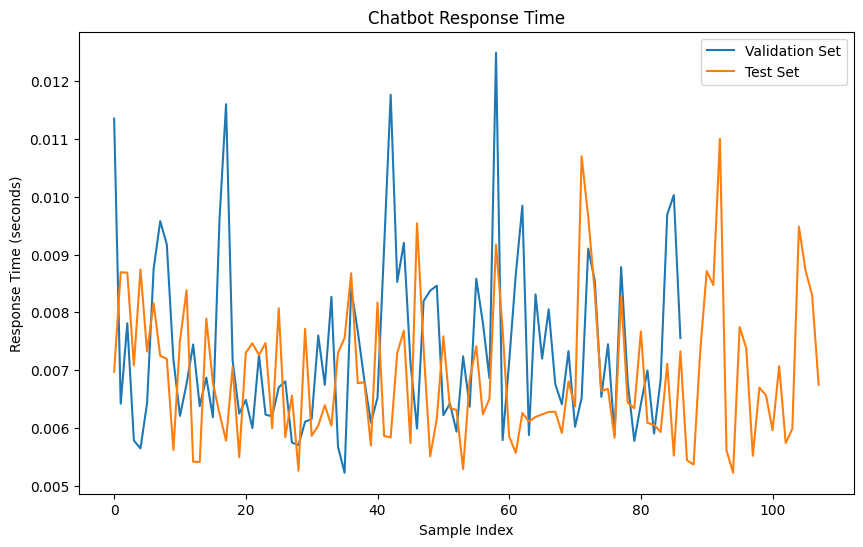

Evaluation Results for Validation Set:
Accuracy: 0.9885057471264368
Precision: 0.9827586206896551
Recall: 0.9885057471264368
Evaluation Results for Test Set:
Accuracy: 0.9722222222222222
Precision: 0.9814814814814815
Recall: 0.9722222222222222
Number of Question-Answer Pairs in the Dataset: 539


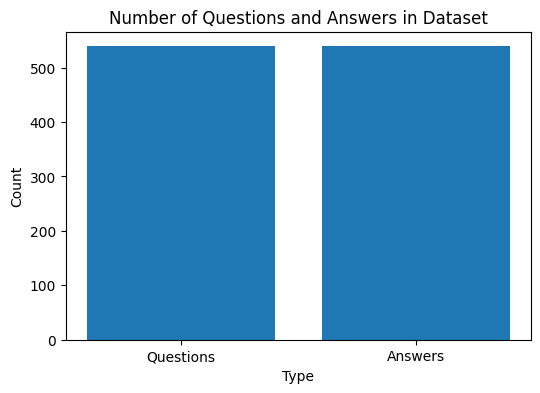

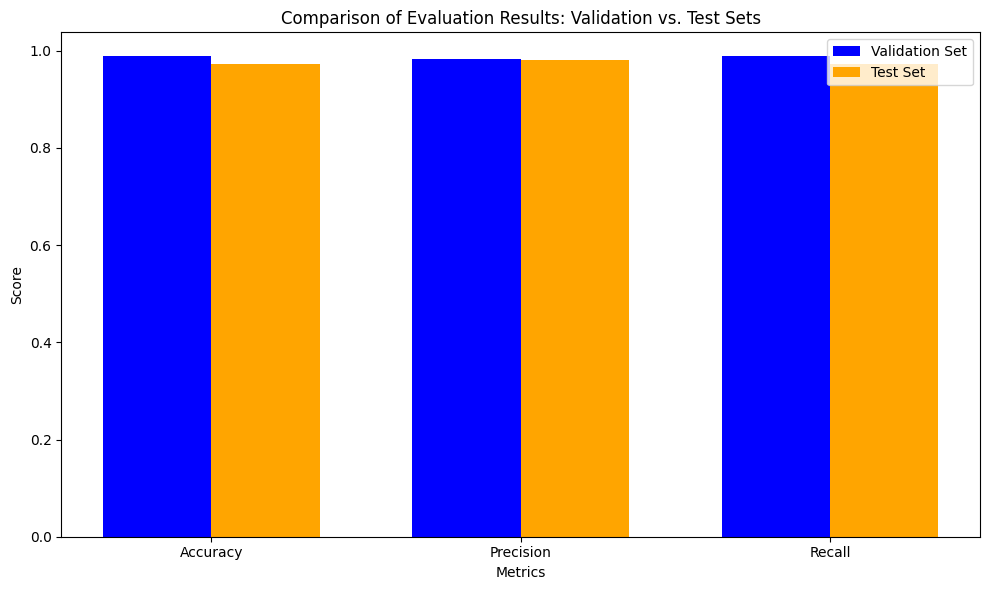

Chatbot: Hello! I'm a retrieval-based chatbot. You can ask me questions about admissions at the University of Hertfordshire.
You: stop
Chatbot: Stopping...


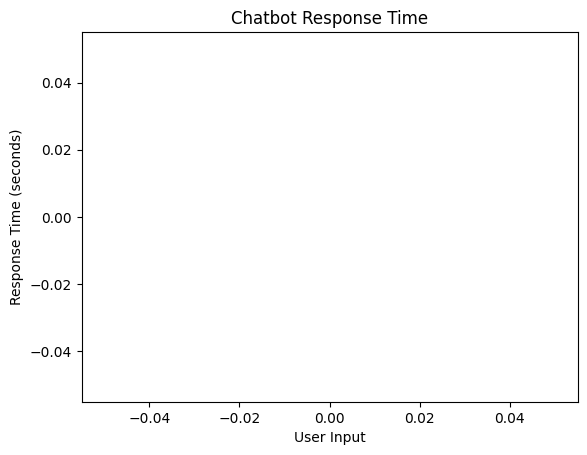

In [1]:
import time
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import json
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Mount Google Drive
drive.mount('/content/drive')

class Chatbot:
    def __init__(self, data_path):
        """
        Initializes the Chatbot instance.

        Args:
            data_path (str): Path to the JSON data file.
        """
        self.data_path = data_path
        self.load_data()
        self.load_spacy_model()
        self.preprocess_data()
        self.initialize_vectorizer()
        self.train_chatbot()

    def load_data(self):
        """
        Loads and processes JSON data.
        """
        with open(self.data_path, 'r') as f:
            self.data = json.load(f)
        self.df = pd.DataFrame(self.data)

    def load_spacy_model(self):
        """
        Loads the SpaCy model.
        """
        self.nlp = spacy.load("en_core_web_sm")

    def preprocess_text(self, text):
        """
        Preprocesses the input text.
        """
        if isinstance(text, list):
            text = ' '.join(text)
        doc = self.nlp(text.lower())
        result = []
        for token in doc:
            if token.text in self.nlp.Defaults.stop_words:
                continue
            if token.is_punct:
                continue
            result.append(token.lemma_)
        return " ".join(result)

    def preprocess_data(self):
        """
        Preprocesses the questions column and adds a processed_questions column to the DataFrame.
        """
        self.df['processed_questions'] = self.df['questions'].apply(self.preprocess_text)

    def initialize_vectorizer(self):
        """
        Initializes a TfidfVectorizer for feature extraction.
        """
        self.vectorizer = TfidfVectorizer()

    def train_chatbot(self):
        """
        Fits the vectorizer and trains the chatbot.
        """
        self.tfidf = self.vectorizer.fit_transform(self.df['processed_questions'])

    def get_response(self, user_input):
        """
        Gets the chatbot's response based on user input.
        """
        preprocessed_input = self.preprocess_text(user_input)
        user_input_vector = self.vectorizer.transform([preprocessed_input])
        cosine_similarities = cosine_similarity(user_input_vector, self.tfidf).flatten()
        index = cosine_similarities.argsort()[-1]

        if cosine_similarities[index] < 0.2:
            return "I'm sorry, I didn't understand that. Can you rephrase your question, please?"
        else:
            return self.df['responses'][index]

    def evaluate_and_plot_response_times(self, validation_df, test_df):
        """
        Evaluates the retrieval-based chatbot on validation and test sets and plots response times.

        Args:
            validation_df (pd.DataFrame): Validation dataset.
            test_df (pd.DataFrame): Test dataset.

        Returns:
            tuple: Validation and test evaluation metrics and response times.
        """
        # Initialize lists to store response times
        validation_response_times = []
        test_response_times = []

        # Initialize prediction and true response lists
        validation_predictions = []
        validation_true_responses = []
        test_predictions = []
        test_true_responses = []

        # Evaluate the retrieval-based chatbot on the validation set
        for _, validation_row in validation_df.iterrows():
            question = validation_row['processed_questions']
            true_response = validation_row['responses']

            # Calculate response time
            start_time = time.time()

            # Get the chatbot's response
            response = self.get_response(question)
            validation_predictions.append(response)
            validation_true_responses.append(true_response)

            # Calculate and store response time
            end_time = time.time()
            response_time = end_time - start_time
            validation_response_times.append(response_time)

        # Evaluate the retrieval-based chatbot on the test set
        for _, test_row in test_df.iterrows():
            question = test_row['processed_questions']
            true_response = test_row['responses']

            # Calculate response time
            start_time = time.time()

            # Get the chatbot's response
            response = self.get_response(question)
            test_predictions.append(response)
            test_true_responses.append(true_response)

            # Calculate and store response time
            end_time = time.time()
            response_time = end_time - start_time
            test_response_times.append(response_time)

        # Calculate evaluation metrics for validation set
        validation_accuracy = accuracy_score(validation_true_responses, validation_predictions)
        validation_precision = precision_score(validation_true_responses, validation_predictions, average='weighted')
        validation_recall = recall_score(validation_true_responses, validation_predictions, average='weighted')

        # Calculate evaluation metrics for test set
        test_accuracy = accuracy_score(test_true_responses, test_predictions)
        test_precision = precision_score(test_true_responses, test_predictions, average='weighted')
        test_recall = recall_score(test_true_responses, test_predictions, average='weighted')

        # Plot the response times
        plt.figure(figsize=(10, 6))
        plt.plot(validation_response_times, label='Validation Set')
        plt.plot(test_response_times, label='Test Set')
        plt.xlabel("Sample Index")
        plt.ylabel("Response Time (seconds)")
        plt.title("Chatbot Response Time")
        plt.legend()
        plt.show()

        return (validation_accuracy, validation_precision, validation_recall,
                test_accuracy, test_precision, test_recall)

    def plot_qa_pair_count(self):
        """
        Plots the number of question-answer pairs in the dataset.
        """
        num_qa_pairs = len(self.df)

        print("Number of Question-Answer Pairs in the Dataset:", num_qa_pairs)

        # Create a bar chart
        plt.figure(figsize=(6, 4))
        plt.bar(['Questions', 'Answers'], [num_qa_pairs, num_qa_pairs])
        plt.xlabel('Type')
        plt.ylabel('Count')
        plt.title('Number of Questions and Answers in Dataset')
        plt.show()

    def plot_evaluation_comparison(self, validation_results, test_results, metrics):
        """
        Plots a comparison of evaluation results between validation and test sets.

        Args:
            validation_results (list): List of evaluation results for the validation set.
            test_results (list): List of evaluation results for the test set.
            metrics (list): List of metric names (e.g., ['Accuracy', 'Precision', 'Recall']).
        """
        # Create a bar chart
        plt.figure(figsize=(10, 6))

        # Bar width
        bar_width = 0.35

        # Bar positions for metrics
        validation_positions = range(len(metrics))
        test_positions = [pos + bar_width for pos in validation_positions]

        # Bar heights for validation and test sets
        plt.bar(validation_positions, validation_results, bar_width, label='Validation Set', color='blue')
        plt.bar(test_positions, test_results, bar_width, label='Test Set', color='orange')

        # X-axis labels and ticks
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Comparison of Evaluation Results: Validation vs. Test Sets')
        plt.xticks([pos + bar_width / 2 for pos in validation_positions], metrics)
        plt.legend()
        plt.tight_layout()

        # Show the plot
        plt.show()

    def interactive_testing(self):
        """
        Performs interactive testing with the chatbot while recording response times.
        """
        response_times = []  # List to store response times

        print("Chatbot: Hello! I'm a retrieval-based chatbot. You can ask me questions about admissions at the University of Hertfordshire.")
        while True:
            user_input = input("You: ")
            if user_input.lower() == 'stop':
                print("Chatbot: Stopping...")
                break
            else:
                start_time = time.time()  # Record the start time
                response = self.get_response(user_input)
                end_time = time.time()  # Record the end time
                response_time = end_time - start_time  # Calculate the response time
                response_times.append(response_time)  # Store the response time
                print("Chatbot:", response)
                print(f"Response Time: {response_time:.4f} seconds")

        # Create a plot of response times
        plt.plot(response_times)
        plt.xlabel("User Input")
        plt.ylabel("Response Time (seconds)")
        plt.title("Chatbot Response Time")
        plt.show()

if __name__ == "__main__":
    # Define data path
    data_path = '/content/drive/MyDrive/Dataset [MConverter.eur].json'

    # Instantiate the Chatbot
    chatbot = Chatbot(data_path)

    # Perform train-validation-test split
    train_df, test_df = train_test_split(chatbot.df, test_size=0.2, random_state=85)
    train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=85)

    # Call the function to evaluate and plot response times
    validation_results = chatbot.evaluate_and_plot_response_times(validation_df, test_df)

    # Retrieve the evaluation metrics from the results
    validation_accuracy, validation_precision, validation_recall, test_accuracy, test_precision, test_recall = validation_results

    # Print evaluation results
    print("Evaluation Results for Validation Set:")
    print("Accuracy:", validation_accuracy)
    print("Precision:", validation_precision)
    print("Recall:", validation_recall)

    print("Evaluation Results for Test Set:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)

    # A bar chart of the number of Q/A pairs
    chatbot.plot_qa_pair_count()

    # Call the function with your evaluation results and metrics
    metrics = ['Accuracy', 'Precision', 'Recall']
    chatbot.plot_evaluation_comparison([validation_accuracy, validation_precision, validation_recall],
                                       [test_accuracy, test_precision, test_recall],
                                       metrics)

    # Call the interactive testing function
    chatbot.interactive_testing()

